# Heat-IBVP-2

This notebook implements the BCGP and PCGP experiments for Heat-IBVP-2 from Section 5.3.2 of the manuscript

## Preliminaries 

Whether to run computations on GPU or CPU

In [1]:
import os

USE_GPU: bool = True

if not USE_GPU:
    os.environ['JAX_PLATFORM_NAME'] = 'cpu'
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

Package imports

In [2]:
import jax.numpy as jnp
from jax import config, random, devices
import jax

import os
import pickle
from numpy import savetxt

# ensure that we can access jax_pigp
import sys
sys.path.append('../../')

import jax_pigp
from jax_pigp.utility_fns import softplus, generate_params, PARAM_OPTIONS_DICT as param_gen_options
from jax_pigp.base import Callable, Array

from functools import partial

from utility_fns import *

# double precision prevents nans
config.update("jax_enable_x64", True) 
# config.update("jax_debug_nans", False) 

Check what devices are available

In [3]:
devices()

[CudaDevice(id=0)]

### Specify settings of the experiments

In [4]:
# base random seed for parameter initialisation
BASE_SEED_VAL: int = 410

# true value of the heat parameter theta 
THETA_TRUE: Array  = jnp.array([1.])

# bounds from which to randomly sample initial value of theta
THETA_MIN: Array = jnp.array([5.])
THETA_MAX: Array = jnp.array([10.])
THETA_BOUNDS = [THETA_MIN, THETA_MAX]

# Set to true to consider inverse problem of identifying theta
RUN_INVERSE: bool = True

# specify how GP handles boundary condnitions 
GP_TYPE = 'bcgp'
assert GP_TYPE in ['bcgp', 'pcgp', 'ucgp'] 

# number of u/f/g space observations to use for inference
N_DATA: int = 250
Nu: int = N_DATA
Nf: int = N_DATA
Nb: int = 500 if GP_TYPE=="pcgp" else 0

# path to subdirectory in ./data where fisher-like equation data is saved
data_save_dir: str = f'heatIBVP2'
data_save_dir_full = os.path.join('data', data_save_dir)
assert os.path.isdir(data_save_dir_full)

# dimensionality of the spatio-temporal domain (including time)
INPUT_DIM: int = 3

# initial value for std of noise levels for u / f / boundary points
NOISE_INIT = jnp.array([0.1, 0.1, 0.1])

# softplus transformation ensures noise and theta values are positive
THETA_TRANSFORM: Callable = softplus
NOISE_TRANSFORM: Callable = softplus

# whether to save all test set prediction results or just summary statistics
SAVE_ALL_PREDICTIONS: bool = False

# options for model training
N_TRAIN_STEPS: int = 10000
N_RESTARTS: int    = 1
LR_INIT: float     = 0.02
VERBOSE: bool      = True

### Specify boundary-constrained mean and kernel functions

The BCGP mean $(\tilde{m})$ and kernel $(\tilde{k})$ functions are presented in Appendix B.2.4 of the manuscript, and they are designed to ensure that the BCGP exactly satisfies the Dirichlet initial condition at $t=0$ and Dirichlet boundary conditions for $x \in \partial \Omega$. These functions take the form

 \begin{align*} 
 \tilde{m}(x,y,t) = & \; \sin(x) \sin(y),  \\
 \tilde{k}([x,y,t], [x',y',t']) = &\; \phi(x,y,t)\phi(x',y',t')k([x,y,t], [x',y',t']),
 \end{align*}

where $k$ is the squared-exponential kernel and the ADF $\phi$ is given by

\begin{equation*}
\phi(x,y,t)  = x (\pi-x)y(\pi-y)t 
\end{equation*}

The above equations are implemented as follows: 

In [5]:
base_kernel = jax_pigp.kernels.squared_exponential

if GP_TYPE == "bcgp":
    print(f'using hard boundary constrained mean and kernel')
    
    def phi(loc: Array):
        x, y, t = loc 
        # we rescale by 2.95 so that maximum value is equal to one
        return x*(jnp.pi - x)*y*(jnp.pi - y)*t / 2.95
    
    def kernel_fn(params: dict, loc1: Array, loc2: Array):

        k_params = params['kernel_params_1']
    
        base_kernel_val = base_kernel(k_params, loc1, loc2)
    
        cov_val = phi(loc1)*phi(loc2)*base_kernel_val
    
        return cov_val.squeeze()
    
    def mean_fn(params: dict, loc: Array):
        x, y, _ = loc 
        return jnp.sin(x)*jnp.sin(y)

else:
    print(f'using unconstrained mean and kernel')
    def kernel_fn(params: dict, loc1: Array, loc2: Array):

        k_params = params['kernel_params_1']
    
        return base_kernel(k_params, loc1, loc2)
    mean_fn= lambda p, loc: loc[0]*0.

using hard boundary constrained mean and kernel


### Specify heat differential operator

Recall that the heat PDE over two spatial dimensions takes the form

$$\mathcal{L}^{\theta}_{x,y,t}[u] =   \frac{\partial u}{\partial t} - \theta\left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)= f = 0,$$
where $\theta$ is the thermal diffusivity coefficient. 

##### Implementation: 

* We define a dummy linear operator for $u$-space data which is just the identity transformation
* $f$ is returned by calling the ``apply_PDE`` function defined below


In [6]:
def apply_Identity(fn: Callable,argnum: int = 1):
    return fn

def apply_PDE(fn: Callable, argnum: int = 1):
    r"""
    Applies the Heat PDE to given input
    fn, evaluated at specified argnum
    """

    # the Jacobian and Hessian functions    
    Jfn, Hfn = jac_hess(fn, argnum)

    def PDE(params: dict, loc1: Array, *loc2: Array):
        ## Note: we assume spatial coords come before temporal value in loc1 and loc2
        
        theta = THETA_TRANSFORM(params['theta'])[0] if RUN_INVERSE else THETA_TRUE[0]

        # time derivative is the final element of the Jacobian vector
        _, _, ut_val = Jfn(params, loc1, *loc2)
            
        # second spatial derivatives are first two values along diagonal of the Hessian matrix
        uxx_val, uyy_val = jnp.diag(Hfn(params, loc1, *loc2))[:-1]
        
        return ut_val - theta*(uxx_val + uyy_val)
    
    return PDE 

# the first operator corresponds to the observations yu, the second
# to pde observations yf, and the final to boundary observations of u
linear_operators = [apply_Identity, apply_PDE, apply_Identity]

### Store settings

Store optimisation options in a dictionary

In [7]:
opt_options = {}
opt_options['n_steps']         = N_TRAIN_STEPS 
opt_options['n_restarts']      = N_RESTARTS
opt_options['lr']              = LR_INIT
opt_options['verbose']         = VERBOSE
opt_options['theta_transform'] = THETA_TRANSFORM
opt_options['noise_transform'] = NOISE_TRANSFORM

Specify parameter initialisation function

In [8]:
param_gen_options['input_dim']       = [INPUT_DIM]
param_gen_options['theta_bounds']    = THETA_BOUNDS
param_gen_options['theta_transform'] = THETA_TRANSFORM
param_gen_options['noise_std_init']  = NOISE_INIT
param_gen_options['noise_transform'] = NOISE_TRANSFORM

# randomly samples kernel parameter values given an input seed
generate_params_fn = lambda seed: generate_params(seed, param_gen_options)

Create a directory to save the results 

In [9]:
results_save_dir = os.path.join('results', data_save_dir, f'{GP_TYPE}_Nu_{Nu}_Nf_{Nf}_Nb_{Nb}')
if not os.path.isdir(results_save_dir): os.makedirs(results_save_dir)

## Data and model initialisation

### Load train and test data

In [10]:
train_data, test_data = load_data(data_save_dir_full, Nu, Nf, Nb)

Check shapes of train and test data

In [11]:
train_data.ytrain.shape, test_data.us.shape, [X.shape for X in train_data.Xtrain]

((500, 1), (500, 1), [(250, 3), (250, 3), (0, 3)])

### Initialise PIGP model

In [12]:
heat_kernel_fns = jax_pigp.interdomain_moments.InterdomainKernelFns(kernel_fn, linear_operators)
heat_mean_fns   = jax_pigp.interdomain_moments.InterdomainMeanFns(mean_fn,     linear_operators)

gp_model = jax_pigp.models.GPR(heat_kernel_fns, heat_mean_fns, noise_trans=NOISE_TRANSFORM)

### Initialise learner for model training

In [13]:
obj_fn_train = lambda params: -gp_model.log_marginal_likelihood(params, train_data)    

gp_learner = jax_pigp.optimisers.AdamLearner(obj_fn_train, opt_options, generate_params_fn, random.PRNGKey(BASE_SEED_VAL))

Initial parameter values  

In [14]:
print_param_values(gp_learner.params, opt_options)

kernel_params_1
amp: [5.60569139]
ls: [1.65025567 1.33145352 3.92439352]
alpha: [11.53558964]

noise_std: [0.1 0.1 0.1]
theta: [5.46905627]


Objective function value for initial parameters

In [15]:
gp_model.log_marginal_likelihood(gp_learner.params, train_data)

Array(-5177.13811678, dtype=float64)

Gradient of the objective function with respect to the initial parameters

In [16]:
gp_learner.grad_obj_fn(gp_learner.params)

(Array(5177.13811678, dtype=float64),
 {'kernel_params_1': {'alpha': Array([0.], dtype=float64),
   'amp': Array([-352.40401523], dtype=float64),
   'ls': Array([-236.52454029, -344.75935484, 1948.17035898], dtype=float64)},
  'noise_std': Array([-1002.83394662, -5553.55643032,     0.        ], dtype=float64),
  'theta': Array([3075.00053325], dtype=float64)})

## Training 

JIT compile the ``update_one_step`` method by evaluating it once, then train model for specified number of steps/restarts.

In [17]:
_ = gp_learner.update_one_step(gp_learner.params, gp_learner.opt_state)

In [18]:
print(f'gp_type={GP_TYPE}, Nu/Nf/Nb={Nu}/{Nf}/{Nb}, n_steps={opt_options['n_steps']}, n_restarts={opt_options['n_restarts']}\n')
gp_learner.train_with_restarts(opt_options['n_steps'], 
                               opt_options['n_restarts'], 
                               print_progress = opt_options['verbose'])

gp_type=bcgp, Nu/Nf/Nb=250/250/0, n_steps=10000, n_restarts=1

Restart 0: beginning training for 10000 steps
(0): 4275.0216, noise_std_vals = [1.02e-01,1.02e-01,1.00e-01], theta = [5.5901522]
(400): -273.1407, noise_std_vals = [1.55e-01,1.37e-01,1.00e-01], theta = [2.76533247]
(800): -1505.6515, noise_std_vals = [2.17e-02,6.41e-03,1.00e-01], theta = [0.99651641]
(1200): -1861.5351, noise_std_vals = [2.18e-02,5.25e-04,1.00e-01], theta = [0.99082247]
(1600): -1878.4526, noise_std_vals = [2.18e-02,2.74e-04,1.00e-01], theta = [0.99017256]
(2000): -1882.1727, noise_std_vals = [2.18e-02,1.94e-04,1.00e-01], theta = [0.98989482]
(2400): -1883.9216, noise_std_vals = [2.18e-02,1.52e-04,1.00e-01], theta = [0.98977517]
(2800): -1885.1556, noise_std_vals = [2.18e-02,1.24e-04,1.00e-01], theta = [0.98972101]
(3200): -1886.3411, noise_std_vals = [2.18e-02,1.05e-04,1.00e-01], theta = [0.98967827]
(3600): -1887.8246, noise_std_vals = [2.18e-02,8.99e-05,1.00e-01], theta = [0.98961019]
(4000): -1890.3167,

### Plot training results

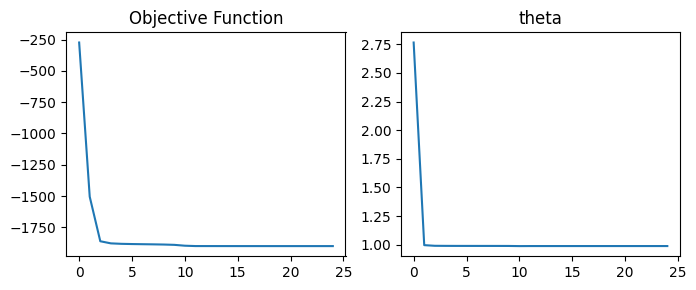

In [19]:
theta_arr = jnp.array(gp_learner.theta_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=TWO_COLUMN_FIGSIZE)

begin_at = int(len(gp_learner.obj_list)*0.05)

plot_lc(axes[0], gp_learner.obj_list[begin_at:], 'Objective Function')
plot_lc(axes[1], theta_arr[begin_at:,0], 'theta')

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'learningCurves.pdf'))

### Final trained parameter values

In [20]:
# extract final trained parameter values
trained_params = gp_learner.params_best.copy()

# print the values of the trained parameters
print_param_values(trained_params, opt_options)

# save trained parameters
with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'wb') as fp:
    pickle.dump(trained_params, fp)

kernel_params_1
alpha: [13.76911183]
amp: [0.3638168]
ls: [3.81693329 3.85620891 1.11795407]

noise_std: [2.17772394e-02 2.65033882e-05 1.00000000e-01]
theta: [0.988569]


Can load pre-trained parameters by uncommenting the below

In [21]:
# with open(os.path.join(results_save_dir, 'trained_params.pkl'), 'rb') as f:
    # trained_params = pickle.load(f)

## Test set results

Evaluate posterior distribution at test points, using hyper-parameter values ``trained_params`` obtained during training phase.

In [22]:
# posterior mean and covariance over test points
print(f'Posterior results for {GP_TYPE}, Nu/Nf/Nb={Nu}/{Nf}/{Nb}, Ns={test_data.Xs.shape[0]}')
mu, Sigma = gp_model.posterior_predict(trained_params, train_data, test_data.Xs)
s = jnp.diag(Sigma)**.5

# save predictions
if SAVE_ALL_PREDICTIONS:
    jnp.save(os.path.join(results_save_dir, 'u_pred.npy'), mu)
    jnp.save(os.path.join(results_save_dir, 's_pred.npy'), s)

# test set prediction error
abs_losses = jnp.abs(mu - test_data.us)
print(f'mean/max loss: {abs_losses.mean():3e}/{abs_losses.max():.3e}')
savetxt(os.path.join(results_save_dir, 'mean_loss.txt'), abs_losses.mean().reshape(-1,1))

if RUN_INVERSE:
    theta_pred = opt_options['theta_transform'](trained_params['theta'])
    theta_loss = jnp.linalg.norm(theta_pred - THETA_TRUE)
    print(f'theta_true : {THETA_TRUE}')
    print(f'theta_pred : {theta_pred}')
    print(f'theta_loss : {theta_loss:.3e}')
    savetxt(os.path.join(results_save_dir, 'theta_loss.txt'), jnp.array([theta_loss]))

Posterior results for bcgp, Nu/Nf/Nb=250/250/0, Ns=500
mean/max loss: 1.238805e-03/4.157e-03
theta_true : [1.]
theta_pred : [0.988569]
theta_loss : 1.143e-02


### Plots of posterior prediction


To make a heat plot, we load and predict on another dataset which has fixed $t=0.5$.

In [23]:
Xs_plot = jnp.load(f'{data_save_dir_full}/Xs_plot.npy')
us_plot = jnp.load(f'{data_save_dir_full}/us_plot.npy')

# write data to TestData object for plotting
test_data_plot = jax_pigp.datasets.TestData(Xs_plot[:,:2], us_plot)

mu_plot, Sigma_plot = gp_model.posterior_predict(trained_params, train_data, Xs_plot)
s_plot = jnp.diag(Sigma_plot)**.5

abs_losses_plot = jnp.abs(mu_plot - us_plot)

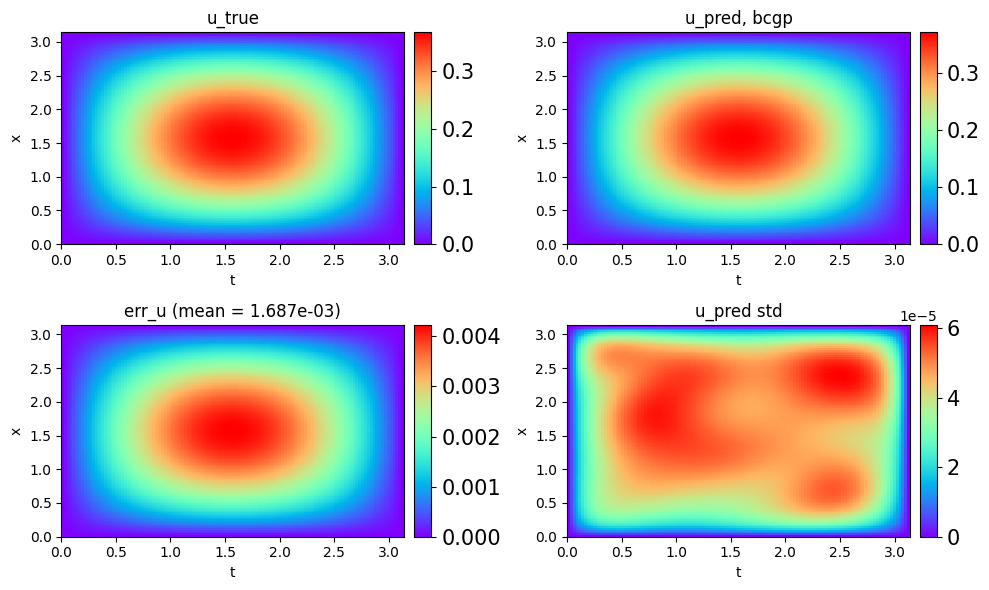

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=TWO_BY_TWO_FIGSIZE)

Nx = len(jnp.unique(test_data_plot.Xs[:,0]))
Nt = len(jnp.unique(test_data_plot.Xs[:,1]))

make_heatmap_heat = lambda ax, output, title=None: make_heatmap(fig, ax, output.reshape(Nt,Nx).T, test_data_plot, None, None, title)

make_heatmap_heat(axes[0,0], us_plot, title='u_true')
make_heatmap_heat(axes[0,1], mu_plot, title=f'u_pred, {GP_TYPE}')
make_heatmap_heat(axes[1,0], abs_losses_plot, title=f'err_u (mean = {abs_losses_plot.mean():.3e})')
make_heatmap_heat(axes[1,1], s_plot, title=f'u_pred std')

fig.tight_layout()

plt.savefig(os.path.join(results_save_dir, 'posteriorPrediction.pdf'))